In [58]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt

In [59]:
'''
150220022 ALI EREN CIFTCI 
'''

'''
First, we need to clean the data in our json file and then convert it into a matrix that we can use.
'''

with open("/Users/alierenciftci/Desktop/archive/sample.json", "r") as file:
    data = json.load(file)

# Create a new list containing only the keys "reviewer", "movie", "rating"
filtered_data = [{"reviewer": d["reviewer"], "movie": d["movie"], "rating": d["rating"]} for d in data]

#Find out how many movies each reviewer rated
reviewer_counts = {}
for d in filtered_data:
    reviewer = d["reviewer"]
    reviewer_counts[reviewer] = reviewer_counts.get(reviewer, 0) + 1

#Delete reviewers who have rated fewer than 20 movies
filtered_data = [d for d in filtered_data if reviewer_counts[d["reviewer"]] >= 20]


df = pd.DataFrame(filtered_data)

df['rating'] = df['rating'].astype(float)

#Make a pivot table
pivot_table = pd.pivot_table(df, values='rating', index='reviewer', columns='movie', fill_value=0)

#Convert to numpy matrix
R = pivot_table.values

In [60]:
'''
I will explain the functions we will use here.
'''
''' 
The first step is to convert the matrix into an R_norm matrix.
So we need functions that find row, column averages and then convert our R matrix into R_norm matrix.
'''
def row_avg(matrix):
    row_averages = []
    for row in matrix:
        non_zero_values = [value for value in row if value != 0]
        if non_zero_values:
            row_average = sum(non_zero_values) / len(non_zero_values)
        else:
            row_average = 0
        row_averages.append(row_average)
    return row_averages


def col_avg(matrix):
  num_cols = len(matrix[0])
  col_averages = [0] * num_cols
  for col in range(num_cols):
    non_zero_count = 0
    col_sum = 0
    for row in matrix:
      if row[col] != 0:
        col_sum += row[col]
        non_zero_count += 1
    if non_zero_count > 0:
      col_averages[col] = col_sum / non_zero_count
    else:
      col_averages[col] = 0 
  return col_averages


def modify_array_elements(matrix, col, row):
    for i in range(len(matrix)):
        for j in range(len(matrix[0])):
            matrix[i][j] += col[j] - row[i]

'''
Then we need to apply SVD to this matrix. QR iteration will be used when applying SVD. 
You can also find the QR decomposition code below, but for efficiency and speed I will use np.linalg.qr. 
You can find the test results of the QR code at the end of the notebook.
'''   
def qr_decomposition(A):
    n = A.shape[1]
    Q = A.astype(float).copy() 
    tol = 1e-8
    j_new = 0  # A variable to track the number of independent columns
    for j in range(n):
        skip_column = False  # A flag to determine whether the column should be omitted
        for k in range(j):
            if np.linalg.norm(Q[:, k]) != 0:
                Q[:, j] -= (np.dot(Q[:, k], Q[:, j])/np.dot(Q[:, k],Q[:, k]))*Q[:, k]
            else:
                skip_column = True  # Dependent column to be neglected
        if not skip_column:
            if np.linalg.norm(Q[:, j]) > tol:
                Q[:, j_new] = Q[:, j] / np.linalg.norm(Q[:, j])
                j_new += 1  # Increase the number of independent columns

    Q = Q[:, :j_new]

    R = np.dot(Q.T, A)
    R = np.triu(R)  
             
    return Q , R   

#Since off-diagonal values in the matrix E are not of interest to us,
#and since it iterates to infinitesmall values anyway, the function deletes those values.
def sifirla_matris(matris):
  satir, sutun = matris.shape
  for i in range(satir):
      for j in range(sutun):
          if i != j:  # Diyagonal dışındaki değerleri kontrol et
              matris[i][j] = 0   

def SVD(matrix, iteration = 2500):
    
    ATA = np.dot(matrix.T,matrix)
    E = ATA.copy()
    V = np.eye(ATA.shape[0])
  
    # with this iteration we first separate a matrix qr, then we find the matrix rq, and so on...
    # after these iterations the initial matrix converges to the matrix with eigenvalues on the diagonal
    # the product of the Qs found since the first iteration approximates the matrix with eigenvectors in the columns.
    for i in range(iteration): 
        Q, R = np.linalg.qr(E)
        V = np.dot(V, Q)
        E = np.dot(R, Q)

    sifirla_matris(E); 

    E = np.sqrt(np.abs(E)) #  Since it's ATA = V E Et V^-1, we need to take the square root of E. 
   
    m , n = E.shape
    Vt = V[:,:n].T # Let's delete the matrices in V that cannot enter the product anyway == Frobenius Form

    U = np.zeros((matrix.shape[0],n))

    for i in range(n): # AV = UE => u_i = A.V_i/sigma_i
        U[:,i] = np.dot(matrix,V[:,i])/E[i,i]

    return U, E, Vt   

def reducing_k(U,E,Vt,k):
    
    U  = U[:, :k] # U'nun sadece ilk k sutununu al 

    E = E[:k, :k] # E'in kxk'lık kısmını al

    Vt = Vt[:k, :] # Vt'nin sadece ilk k satirini al
    return U, E, Vt  

''' 
After these steps, the last parts of our algorithm, finding similarity and prediction 
'''
def calculating_prediction(U,E,Vt,averages_reviewer,user_a, item_j, reduce_k, neighbor_L):
  
  Uk, Ek ,Vtk = reducing_k(U,E,Vt,reduce_k)
 
  R_red = np.dot(np.dot(Uk,Ek),Vtk) #R_red[i,j] = rrij denotes the rating by user ui on item ij as included in this reduced matrix.

  meta_ratings = np.dot(np.sqrt(Ek),Vtk) # meta_ratings[i,j] = A ”meta” rating assigned by pseudo-user ui on item ij is denoted

  # finding similarity We need to find the L movies that are most similar to item j.

  sim_values = []
    # Loop the number of columns of vtk
  for f in range(Vtk.shape[1]):
      sim_pay = 0
      sim_payda1 = 0
      sim_payda2 = 0
        
        # Calculation operations
      for i in range(meta_ratings.shape[0]):
          sim_pay += (meta_ratings[i, item_j] * meta_ratings[i, f])
          sim_payda1 += ((meta_ratings[i, item_j]) ** 2)
          sim_payda2 += ((meta_ratings[i, f]) ** 2)  
      # Calculate the similarity value and save it to array with indexes.
      sim_j = sim_pay / np.sqrt(sim_payda1 * sim_payda2)
      sim_values.append((f,sim_j))
    
  sim_values = sorted(sim_values, key=lambda x: x[1], reverse=True)
  sim_values = sim_values[:neighbor_L]# The similarity values of the L most similar movies were taken.
  #print(sim_values)

  # prediction generation

  pre_pay = 0.0
  pre_payda = 0.0
  for k in range(neighbor_L):
      pre_pay = pre_pay + sim_values[k][1]*(R_red[user_a,sim_values[k][0]] + averages_reviewer[user_a])
      pre_payda = pre_payda + np.abs(sim_values[k][1])

  prediction = pre_pay / pre_payda  
  return prediction         

user = 1


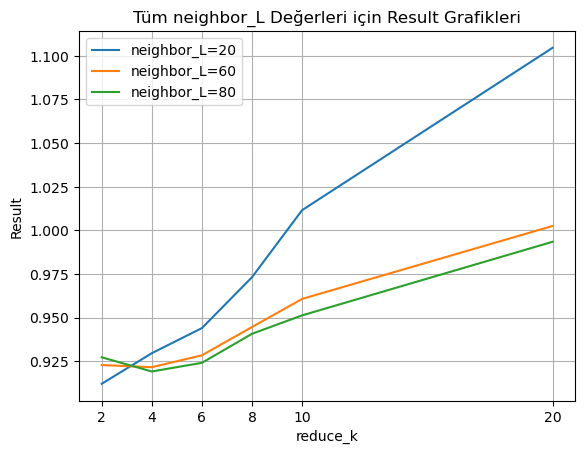

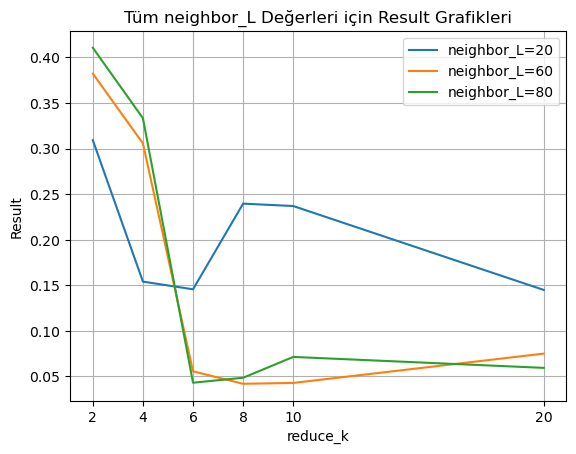

In [61]:
R_norm = R.copy()

#Only 1000 movies for reducing calculation time
R_norm = R_norm[:,:1000]
R = R[:,:1000]

averages_reviewer = row_avg(R_norm)
averages_movies = col_avg(R_norm)

modify_array_elements(R_norm, averages_movies, averages_reviewer)

U, E, Vt = SVD(R_norm)

# Now we need to make a prediction for these following values

neighbor_L_values = [20,60,80]
reduce_k_values = [2,4,6,8,10,20]

'''
This following fragment finds MAE by looking at all users in general
'''
total_MAE_values = {}

user = np.where(np.any(R != 0, axis=1))[0]
# Loop to calculate MAE values for each user
for user_a in user:
    item_j = np.nonzero(R[user_a])[0].tolist()  # Get movies with values other than 0
    size_j = len(item_j)
    output_cache = {}  # Let's create a dictionary to store values

    # Let's calculate MAE values for each combination
    for neighbor_L in neighbor_L_values:
        for reduce_k in reduce_k_values:
            key = (reduce_k, neighbor_L)  # Generate a key for each combination
            outputs = []
            for movie in item_j:
                prediction = calculating_prediction(U, E, Vt,averages_reviewer, user_a, movie, reduce_k, neighbor_L)
                outputs.append(prediction)
            output_cache[key] = outputs

    # Let's calculate the MAE values for this user
    for key in output_cache:
        total_error = 0
        for i in range(size_j):
            total_error += abs(output_cache[key][i] - R[user_a, item_j[i]])
        MAE = total_error / size_j
        # Create a dictionary to collect the MAE value for each key
        if key not in total_MAE_values:
            total_MAE_values[key] = 0
        total_MAE_values[key] += MAE
        
# Let's calculate the average MAE values for each key
average_MAE_values = {}
for key in total_MAE_values:
    average_MAE_values[key] = total_MAE_values[key] / len(user)

''' 
This following is the part where I found MAE for one user only,
without getting stuck in the for loop for the user while testing the code.
'''  
user_a1 = 1 # INPUT
print("user =",user_a1)
item_j1 = np.nonzero(R[user_a1])[0].tolist() 
size_j1 = len(item_j1) 
output_cache1 = {} 

for neighbor_L in neighbor_L_values:
    for reduce_k in reduce_k_values:
        key = (reduce_k, neighbor_L)  
        outputs = []
        for movie in item_j1:
            prediction = calculating_prediction(U,E,Vt,averages_reviewer,user_a1, movie, reduce_k, neighbor_L)
            outputs.append(prediction)
        output_cache1[key] = outputs    
for key in output_cache1:
    toplam = 0
    for i in range(size_j1):
        toplam += abs(output_cache1[key][i]-R[user_a1,item_j1[i]])
    output_cache1[key] = (toplam/size_j1)  

'''
Now it is time to put it on a graph, where we will find the MAE for user 1 and overall. 
'''    
''' 
For all users
'''
for neighbor_L in neighbor_L_values:
    result_values = []  # sonuç değerlerini saklamak için boş bir liste
    
    # Her bir reduce_k değeri için sonuçları al
    for reduce_k in reduce_k_values:
        key = (reduce_k, neighbor_L)  # Her bir kombinasyon için anahtar oluştur
        result = average_MAE_values[key]  # Sonucu al
        result_values.append(result)  # Sonucu listeye ekle
    
    # Grafik çizimi
    plt.plot(reduce_k_values, result_values, label=f'neighbor_L={neighbor_L}')
plt.xticks(reduce_k_values)
plt.xlabel('reduce_k')
plt.ylabel('Result')
plt.title('Tüm neighbor_L Değerleri için Result Grafikleri')
plt.legend()  # Label'ları göster
plt.grid(True)
plt.show()

''' 
For user 1
'''
for neighbor_L in neighbor_L_values:
    result_values = []  # sonuç değerlerini saklamak için boş bir liste
    
    # Her bir reduce_k değeri için sonuçları al
    for reduce_k in reduce_k_values:
        key = (reduce_k, neighbor_L)  # Her bir kombinasyon için anahtar oluştur
        result = output_cache1[key]  # Sonucu al
        result_values.append(result)  # Sonucu listeye ekle
    
    # Grafik çizimi
    plt.plot(reduce_k_values, result_values, label=f'neighbor_L={neighbor_L}')
plt.xticks(reduce_k_values)
plt.xlabel('reduce_k')
plt.ylabel('Result')
plt.title('Tüm neighbor_L Değerleri için Result Grafikleri')
plt.legend()  # Label'ları göster
plt.grid(True)
plt.show()



In [62]:
# Test için bir matris oluşturalım
A = np.array(([1,2,3],
             [4,5,6]))

K,M = qr_decomposition(A)
print("FOR QR")
print("A:")
print(A)
print("Q:")
print(K)
print("R:")
print(M)
print(K@M)
''' 
SVD yi deneyelim
'''
print("FOR SVD:")
U1,S1,Vt1 = SVD(A)
print("A:")
print(A)
print("U:")
print(U1)
print("E:")
print(S1)
print("Vt:")
print(Vt1)
print(U1@S1@Vt1)


FOR QR
A:
[[1 2 3]
 [4 5 6]]
Q:
[[ 0.24253563  0.9701425 ]
 [ 0.9701425  -0.24253563]]
R:
[[4.12310563 5.33578375 6.54846188]
 [0.         0.72760688 1.45521375]]
[[1. 2. 3.]
 [4. 5. 6.]]
FOR SVD:
A:
[[1 2 3]
 [4 5 6]]
U:
[[ 3.86317703e-01  9.22365780e-01  1.11518169e-07]
 [ 9.22365780e-01 -3.86317703e-01 -3.77446110e-08]]
E:
[[9.50803200e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.72869636e-01 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 3.23554885e-08]]
Vt:
[[ 0.42866713  0.56630692  0.7039467 ]
 [-0.80596391 -0.11238241  0.58119908]
 [ 0.40824829 -0.81649658  0.40824829]]
[[1. 2. 3.]
 [4. 5. 6.]]
